# Sensor Modeling

This tutorial demonstrates how to model sensor geometries.

# Setup

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go

from ostk.mathematics.geometry.d2 import Object
from ostk.mathematics.geometry.d2.objects import Point as Point2d
from ostk.mathematics.geometry.d2.objects import LineString as LineString2d
from ostk.mathematics.geometry.d2.objects import Polygon as Polygon2d
from ostk.mathematics.geometry.d3.objects import Point as Point3d
from ostk.mathematics.geometry.d3.objects import Polygon as Polygon3d
from ostk.mathematics.geometry.d3.objects import Ellipsoid
from ostk.mathematics.geometry.d3.objects import Pyramid
from ostk.mathematics.geometry.d3.objects import Cone
from ostk.mathematics.geometry.d3.transformations.rotations import Quaternion
from ostk.mathematics.geometry.d3.transformations.rotations import RotationVector
from ostk.mathematics.geometry.d3.transformations.rotations import RotationMatrix

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate.spherical import AER
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Velocity
from ostk.physics.coordinate import Frame
from ostk.physics.coordinate import Transform
from ostk.physics.coordinate.frame.providers import Dynamic as DynamicFrameProvider
from ostk.physics import Environment
from ostk.physics.environment.object import Geometry
from ostk.physics.environment.objects import Celestial
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE
from ostk.astrodynamics.trajectory.orbit.models import SGP4
from ostk.astrodynamics.trajectory.orbit.models.sgp4 import TLE
from ostk.astrodynamics import Access

---

## Computation

### Environment

In [2]:
environment = Environment.default()

In [3]:
earth = environment.access_celestial_object_with_name("Earth")

In [4]:
earth_geometry = earth.get_geometry_in(Frame.ITRF())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [5]:
a = Length.kilometers(7000.0)
e = 0.0
i = Angle.degrees(45.0)
raan = Angle.degrees(0.0)
aop = Angle.degrees(0.0)
nu = Angle.degrees(0.0)

coe = COE(a, e, i, raan, aop, nu)

In [6]:
epoch = Instant.date_time(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC)

keplerian_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No, True) # True = COE expressed in ITRF frame

In [7]:
keplerian_model.get_classical_orbital_elements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         6999999.9999999972 [m]                   
    Eccentricity:                            2.6250607414312717e-16                   
    Inclination:                             44.972897836604517 [deg]                 
    Right ascension of the ascending node:   343.91390293099067 [deg]                 
    Argument of periapsis:                   0.0 [deg]                                
    True anomaly:                            359.86030748978823 [deg]                 
----------------------------------------------------------------------------------------------------

We then obtain the satellite orbit (which is a trajectory):

In [8]:
satellite_orbit = Orbit(keplerian_model, earth)

In [9]:
start_instant = Instant.date_time(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC) ;
end_instant = start_instant + coe.get_orbital_period(Earth.gravitational_parameter) ;

interval = Interval.closed(start_instant, end_instant) ;

In [10]:
step = Duration.seconds(300.0)

In [11]:
instants = interval.generate_grid(step)

In [12]:
states = [satellite_orbit.get_state_at(instant) for instant in instants]

In [13]:
states_lla = [LLA.cartesian(state.in_frame(Frame.ITRF()).get_position().get_coordinates(), Earth.equatorial_radius, Earth.flattening) for state in states]

In [14]:
states_line_string = LineString2d([Point2d(state_lla.get_longitude().in_degrees(), state_lla.get_latitude().in_degrees()) for state_lla in states_lla])

In [15]:
ground_track_df = pd.DataFrame([[float(state_lla.get_longitude().in_degrees()), float(state_lla.get_latitude().in_degrees())] for state_lla in states_lla], columns=['Longitude', 'Latitude']) ;

In [16]:
ground_track_df.head()

,Longitude,Latitude
0,3.356969e-12,3.376763e-12
1,1.207971e+01,1.306305e+01
2,2.559488e+01,2.535757e+01
3,4.214941e+01,3.585366e+01
4,6.306843e+01,4.302728e+01


## Target

In [17]:
latitude = Angle.degrees(0.0)
longitude = Angle.degrees(0.0)
altitude = Length.meters(10.0)

In [18]:
target_lla = LLA(latitude, longitude, altitude)

In [19]:
target_position = Position.meters(target_lla.to_cartesian(Earth.equatorial_radius, Earth.flattening), Frame.ITRF())

### Sensor

In [20]:
orbital_frame = satellite_orbit.get_orbital_frame(Orbit.FrameType.NED)
orbital_frame = satellite_orbit.get_orbital_frame(Orbit.FrameType.VVLH)

In [21]:
alt_states = [orbital_frame.get_origin_in(Frame.GCRF(), instant) for instant in instants]

In [22]:
alt_states_lla = [
    LLA.cartesian(
        orbital_frame.get_origin_in(Frame.ITRF(), instant).get_coordinates(),
        Earth.equatorial_radius,
        Earth.flattening
    )
    for instant in instants
]

In [23]:
alt_ground_track_df = pd.DataFrame([[float(state_lla.get_longitude().in_degrees()), float(state_lla.get_latitude().in_degrees())] for state_lla in alt_states_lla], columns=['Longitude', 'Latitude']) ;

In [24]:
ground_track_df = alt_ground_track_df

In [25]:
axes = [np.transpose(orbital_frame.get_axes_in(Frame.GCRF(), instant).x()) for instant in instants]

In [104]:
def calculate_attitude (state, target):

    q_ORB_GCRF = Frame.GCRF().get_transform_to(orbital_frame, state.get_instant()).get_orientation()
    
    q_B_ORB = Quaternion.unit()
    q_B_ORB = Quaternion.rotation_vector(RotationVector.x(Angle.degrees(0.0)))
    
    q_B_GCRF = (q_B_ORB * q_ORB_GCRF).to_normalized()
    
    return q_B_GCRF

In [105]:
def body_frame_transform_generator (instant):
    
    state = satellite_orbit.get_state_at(instant)
    
    q_B_GCRF = calculate_attitude(state, target_position)
    
    return Transform.passive(instant, -state.get_position().get_coordinates(), np.array((0.0, 0.0, 0.0)), q_B_GCRF, np.array((0.0, 0.0, 0.0)))

body_frame_provider = DynamicFrameProvider(body_frame_transform_generator)

if Frame.exists("Body"):
    Frame.destruct("Body")

body_frame = Frame.construct("Body", False, Frame.GCRF(), body_frame_provider)

In [106]:
def calculate_intersection (target, state, sensor_geometry):

    target_lla = LLA.cartesian(target.get_coordinates(), Earth.equatorial_radius, Earth.flattening)

    ned_frame = earth.get_frame_at(target_lla, Celestial.FrameType.NED)
    
    target_position_NED = target.in_frame(ned_frame, state.get_instant())
    satellite_position_NED = state.get_position().in_frame(ned_frame, state.get_instant())

    aer = AER.from_position_to_position(target_position_NED, satellite_position_NED)
    
    observer_geometry_ITRF = sensor_geometry.in_frame(Frame.ITRF(), state.get_instant())
    
    intersection_ITRF = observer_geometry_ITRF.intersection_with(earth_geometry)
    
    if not intersection_ITRF.is_defined():
    
        return None
    
    intersection_points = [Point2d(lla.get_longitude().in_degrees(), lla.get_latitude().in_degrees()) for lla in [LLA.cartesian(point_ITRF.as_vector(), Earth.equatorial_radius, Earth.flattening) for point_ITRF in intersection_ITRF.access_composite().access_object_at(0).as_line_string()]]
    
    if len(intersection_points) < 3:
        
        return None

    intersection_polygon = Polygon2d(intersection_points)
    
    return intersection_ITRF

In [107]:
apex_B = Point3d(0.0, 0.0, 0.0)
base_B = Polygon3d(Polygon2d([Point2d(-1.0, -1.0), Point2d(+1.0, -1.0), Point2d(+1.0, +1.0), Point2d(-1.0, +1.0)]), apex_B + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid_B = Pyramid(base_B, apex_B)

In [108]:
from ostk.mathematics.geometry import Angle

cone_B = Cone(apex_B, np.array((0.0, 0.0, 1.0)), Angle.degrees(40.0))

In [109]:
sensor_geometry = Geometry(pyramid_B, body_frame)

In [110]:
intersections_ITRF = [calculate_intersection(target_position, state, sensor_geometry) for state in states]

In [111]:
intersections_ITRF = [intersection_ITRF for intersection_ITRF in intersections_ITRF if intersection_ITRF is not None]

In [112]:
intersections_LLs = [[Point2d(lla.get_longitude().in_degrees(), lla.get_latitude().in_degrees()) for lla in [LLA.cartesian(point_ITRF.as_vector(), Earth.equatorial_radius, Earth.flattening) for point_ITRF in intersection_ITRF.access_composite().access_object_at(0).as_line_string()]] for intersection_ITRF in intersections_ITRF]

In [113]:
intersection_dfs = [pd.DataFrame([[float(intersection_point.x()), float(intersection_point.y())] for intersection_point in intersection_LLs], columns=['Longitude', 'Latitude']) for intersection_LLs in intersections_LLs] ;

In [114]:
intersection_dfs[0].head()

,Longitude,Latitude
0,-8.915019,3.339982e-12
1,-7.484489,-1.152781e+00
2,-6.373103,-2.114364e+00
3,-5.433459,-2.975470e+00
4,-4.586204,-3.792032e+00


---

## Visualization

2D plot:

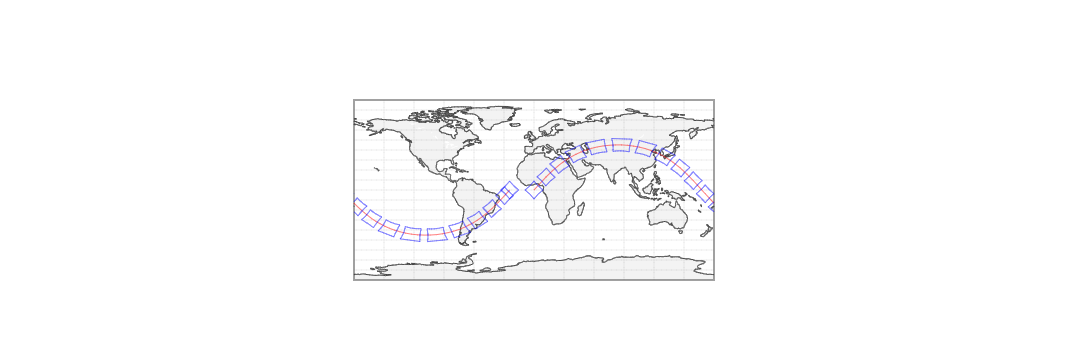

In [115]:
data = []

data.append(
    go.Scattergeo(
        lon = ground_track_df['Longitude'],
        lat = ground_track_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'rgba(255, 0, 0, 0.5)',
        )
    )
)

for intersection_df in intersection_dfs:

    data.append(
        go.Scattergeo(
            lon = intersection_df['Longitude'],
            lat = intersection_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'rgba(0, 0, 255, 0.5)',
            )
        )
    )
    
figure = go.Figure(
    data = data,
    layout = go.Layout(
        title = None,
        showlegend = False,
        height=1000,
        geo = go.layout.Geo(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.1
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.1
            )
        )
    )
)

figure.show()

3D plot:

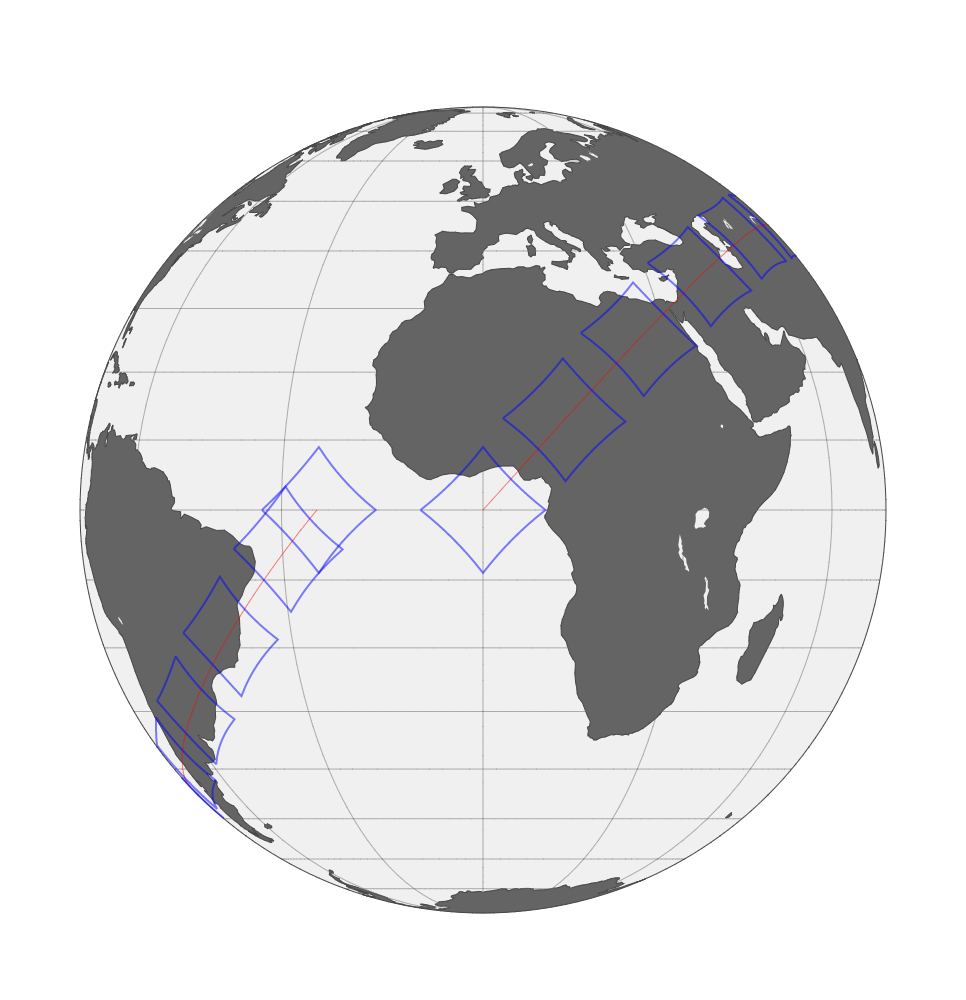

In [116]:
data = []

data.append(
    go.Scattergeo(
        lon = ground_track_df['Longitude'],
        lat = ground_track_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'rgba(255, 0, 0, 0.5)'
        )
    )
)

for intersection_df in intersection_dfs:
    
    data.append(
        go.Scattergeo(
            lon = intersection_df['Longitude'],
            lat = intersection_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 2,
                color = 'rgba(0, 0, 255, 0.5)',
            )
        )
    )
    
figure = go.Figure(
    data = data,
    layout = go.Layout(
        title = None,
        showlegend = False,
        height = 1000,
        geo = go.layout.Geo(
            showland = True,
            showlakes = True,
            showcountries = False,
            showocean = True,
            countrywidth = 0.0,
            landcolor = 'rgb(100, 100, 100)',
            lakecolor = 'rgb(240, 240, 240)',
            oceancolor = 'rgb(240, 240, 240)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(
                    lon = 0,
                    lat = 0,
                    roll = 0
                )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )
)

figure.show()

Satellite body frame orientation plot:

In [117]:
def earth_data ():
    
    theta = np.linspace(0, 2 * np.pi, 30)
    phi = np.linspace(0, np.pi, 30)

    theta_grid, phi_grid = np.meshgrid(theta, phi)

    r = float(Earth.equatorial_radius.in_meters())

    x = r * np.cos(theta_grid) * np.sin(phi_grid)
    y = r * np.sin(theta_grid) * np.sin(phi_grid)
    z = r * np.cos(phi_grid)

    earth = go.Surface(
        x=x,
        y=y,
        z=z,
        colorscale='Viridis',
        showscale=False
    )
    
    return earth

In [118]:
def orbit_data (states):
    
    states_GCRF = [state.in_frame(Frame.GCRF()).get_position().get_coordinates() for state in states]

    trace = go.Scatter3d(
        x = [state_GCRF[0] for state_GCRF in states_GCRF],
        y = [state_GCRF[1] for state_GCRF in states_GCRF],
        z = [state_GCRF[2] for state_GCRF in states_GCRF],
        mode = 'lines',
        marker = dict(
            size = 0,
            showscale = False
        ),
        line = dict(
            width = 1
        )
    )
    
    return trace

In [119]:
def frame_data (frame, instants, scale):
    
    frame_origins_GCRF = [frame.get_origin_in(Frame.GCRF(), instant).get_coordinates() for instant in instants]
    frame_axess_GCRF = [frame.get_axes_in(Frame.GCRF(), instant) for instant in instants]
    
    def axis_data (origin, axis, color):
    
        data = go.Scatter3d(
            x = [origin[0], origin[0] + scale * axis[0]],
            y = [origin[1], origin[1] + scale * axis[1]],
            z = [origin[2], origin[2] + scale * axis[2]],
            marker = dict(
                size = 1
            ),
            line = dict(
                color = color,
                width = 6
            )
        )
        
        return data
    
    data = []
    
    for [frame_origin_GCRF, frame_axes_GCRF] in zip(frame_origins_GCRF, frame_axess_GCRF):
        
        data.append(axis_data(frame_origin_GCRF, frame_axes_GCRF.x(), "red"))
        data.append(axis_data(frame_origin_GCRF, frame_axes_GCRF.y(), "blue"))
        data.append(axis_data(frame_origin_GCRF, frame_axes_GCRF.z(), "green"))
    
    return data

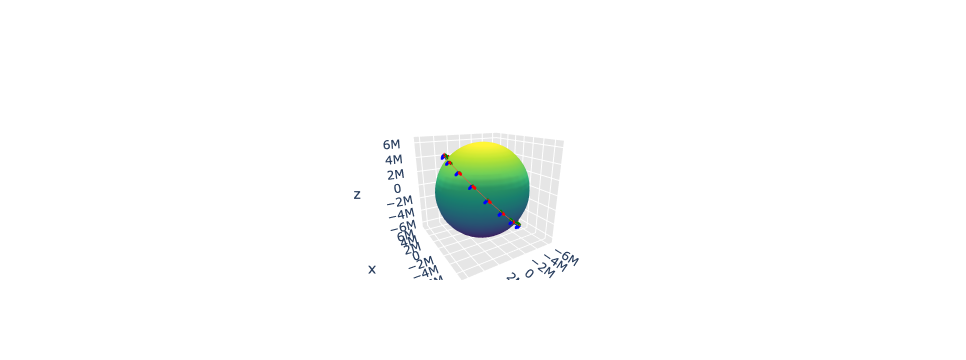

In [120]:
figure = go.Figure(
    data = [
        earth_data(),
        orbit_data(states),
        *frame_data(body_frame, instants, scale = 500000)
    ],
    layout = go.Layout(
        title = None,
        showlegend = False,
        scene = dict(
            xaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                backgroundcolor = 'rgb(230, 230,230)'
            ),
            yaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                backgroundcolor = 'rgb(230, 230,230)'
            ),
            zaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                backgroundcolor = 'rgb(230, 230,230)'
            ),
            camera = dict(
                up = dict(
                    x = 0,
                    y = 0,
                    z = 1
                ),
                eye = dict(
                    x = -1.7428,
                    y = 1.0707,
                    z = 0.7100,
                )
            ),
            aspectratio = dict(x = 1, y = 1, z = 1),
            aspectmode = 'manual'
        )
    )
)

figure.show()

---